In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

In [5]:
INDIV_PATH = "D:/CEFE/indiv/224/"

In [6]:
import os
nb_individual = len(os.listdir(os.path.join(INDIV_PATH, "test")))
print(nb_individual)

342


In [7]:
import pandas as pd

test_dataset = []

# Iterate over the folders (individuals)
for indiv in os.listdir(os.path.join(INDIV_PATH, "test")):
  for picturename in os.listdir(os.path.join(INDIV_PATH, "test", indiv)):
    test_dataset.append({'individual':indiv, 'path': os.path.join(INDIV_PATH, "test", indiv, picturename)})

# Prepare a dataframe and preview it
test_dataset = pd.DataFrame(test_dataset)
test_dataset.head(10)

,individual,path
0,BF001,D:/CEFE/indiv/224/test\BF001\BF001_2021_@P.Lou...
1,BF002,D:/CEFE/indiv/224/test\BF002\BF002_2021_@P.Lou...
2,BF003,D:/CEFE/indiv/224/test\BF003\BF003_2021_@P.Lou...
3,BF004,D:/CEFE/indiv/224/test\BF004\BF004_2021_@P.Lou...
4,BF004,D:/CEFE/indiv/224/test\BF004\BF004_2021_@P.Lou...
5,BF004,D:/CEFE/indiv/224/test\BF004\BF004_2021_@P.Lou...
6,BF005,D:/CEFE/indiv/224/test\BF005\BF005_2021_@P.Lou...
7,BF006,D:/CEFE/indiv/224/test\BF006\BF006_2021_@P.Lou...
8,BF006,D:/CEFE/indiv/224/test\BF006\BF006_2021_@P.Lou...
9,BF006,D:/CEFE/indiv/224/test\BF006\BF006_2021_@P.Lou...


In [8]:
train_dataset = []

# Iterate over the folders (individuals)
for indiv in os.listdir(os.path.join(INDIV_PATH, "train")):
  for picturename in os.listdir(os.path.join(INDIV_PATH, "train", indiv)):
    train_dataset.append({'individual':indiv, 'path': os.path.join(INDIV_PATH, "train", indiv, picturename)})

# Prepare a dataframe and preview it
train_dataset = pd.DataFrame(train_dataset)
train_dataset.head(10)

,individual,path
0,BF001,D:/CEFE/indiv/224/train\BF001\BF001_2021_@P.Lo...
1,BF001,D:/CEFE/indiv/224/train\BF001\BF001_2021_@P.Lo...
2,BF001,D:/CEFE/indiv/224/train\BF001\BF001_2021_@P.Lo...
3,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
4,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
5,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
6,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
7,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
8,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...
9,BF002,D:/CEFE/indiv/224/train\BF002\BF002_2021_@P.Lo...


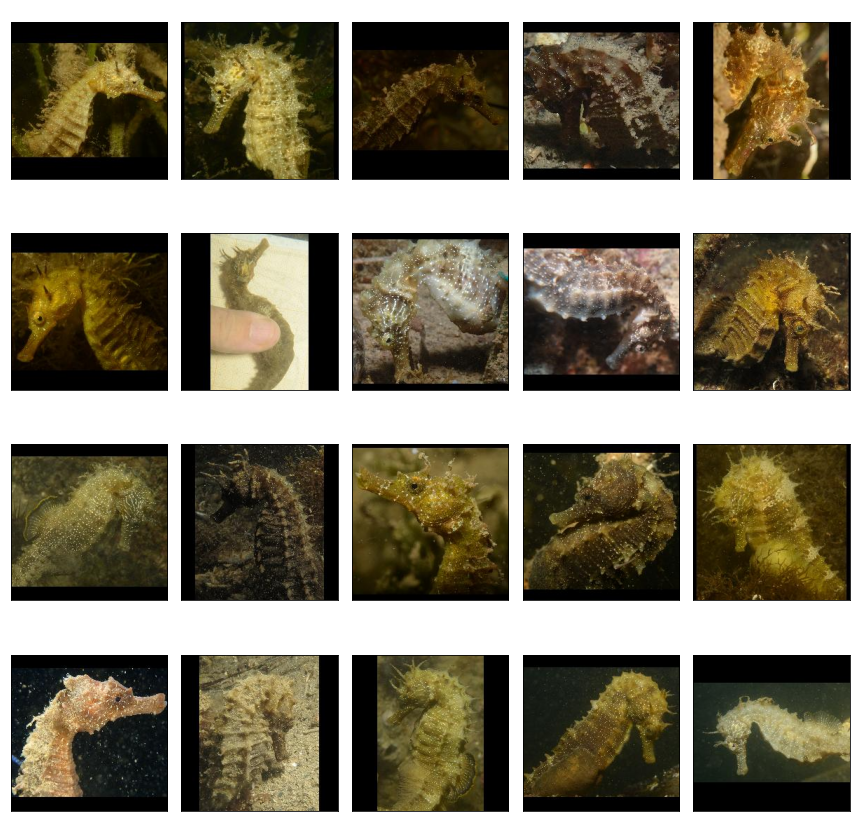

In [9]:
# Visualizing a few samples
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i in range(20):
    idx = np.random.randint(0, len(train_dataset))
    img = plt.imread(train_dataset['path'].iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(train_dataset['individual'].iloc[idx], fontdict={"color":"white"})
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [10]:
min_images_par_class = np.min(train_dataset["individual"].value_counts())

In [11]:
from kerasgen.balanced_image_dataset import balanced_image_dataset_from_directory

train_ds = balanced_image_dataset_from_directory(
    os.path.join(INDIV_PATH, "train"), num_classes_per_batch=10,
    num_images_per_class=min_images_par_class, image_size=(224, 224),
    validation_split=0.1, subset='training', seed=555,
    safe_triplet=True)

val_ds = balanced_image_dataset_from_directory(
    os.path.join(INDIV_PATH, "train"), num_classes_per_batch=10,
    num_images_per_class=min_images_par_class, image_size=(224, 224),
    validation_split=0.1, subset='validation', seed=555,
    safe_triplet=True)

Found 12977 files belonging to 308 classes.
Using 11680 files for training.
Found 12977 files belonging to 308 classes.
Using 1297 files for validation.


In [12]:
from tqdm import tqdm

images, labels = [], []

# Iterate over the rows of the newly created dataframe
for (_, row) in tqdm(test_dataset.iterrows()):
    # Read the image from the disk, resize it, and scale the pixel
    # values to [0,1] range
    image = plt.imread(row['path'])
    images.append(image)

    # Parse the name of the person
    labels.append(row['individual'])

images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

1661it [00:15, 109.67it/s]

(1661, 224, 224, 3) (1661,)


In [13]:
def embedding_model(embedding_dim, pretrained_model):
    # Create the placeholder for the input image and run it through our pre-trained
    # VGG16 model. Note that we will be fine-tuning this feature extractor but it will still
    # run in *inference model* making sure the BatchNorm layers are not training.
    inputs = keras.layers.Input(shape=pretrained_model.input_shape[1:])
    features = pretrained_model(inputs, training=False)
    
    # Create the upper half of our model where we pool out the extracted features,
    # pass it through a mini fully-connected network. We also force the embeddings 
    # to remain on a unit hypersphere space.
    x = keras.layers.GlobalAveragePooling2D()(features)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dense(embedding_dim)(x)
    outputs = keras.layers.Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(x)
    
    # Create the final model
    model = keras.models.Model(inputs, outputs)

    return model

In [14]:
# Create a utility to plot the training losses
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history['loss'], label='train_loss')
        plt.plot(H.history['val_loss'], label='val_loss')
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

In [15]:
# Define the LR schedule constants
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [16]:
# Define the LR schedule as a callback
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

In [17]:
# Define a `EarlyStopping` callback so that our model does overfit 
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=2, mode='auto',
    restore_best_weights=True
)

In [18]:
import tensorflow_addons as tfa

vgg_16 = tf.keras.applications.VGG16(weights='imagenet', # Load weights pre-trained on ImageNe
    include_top=False, # Do not include the ImageNet classifier at the top
    input_shape=(224, 224, 3)
)
vgg_16.trainable = True # We will be fine-tuning feature extractor network

# Initialize the model. Here we are extracting 128-dimensional embedding vectors. This is
# a hyperparameter you might want to experiment with. 
model = embedding_model(128, vgg_16)

# Compile the model with TripletLoss
model.compile(optimizer=tf.keras.optimizers.Adam(), 
    # According to the FaceNet paper, Semi-hard Triplet Mining yielded good results. 
    loss=tfa.losses.TripletSemiHardLoss() 
)

# Train the model and visualize the training progress
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[lr_callback, es])
plot_training(history, 128)

58900480/58889256 [==============================] - 14s 0us/step

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50


In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((images, labels)).\
    cache().\
    batch(64).\
    prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Extract embeddings from the test images
test_features = model.predict(test_ds)

# Train a nearest neighbors model with the extracted embeddings. Here we are limiting it
# to *5 neighbors* only. 
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(test_features)